<a target="_blank" href="https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

If you have any problems opening it in colab, check the footer of this notebook.

# ISPR - Midterm 3 - Assignment 1: Denoising Autoencoder

*Author: Leonardo Crociani - Student ID: 615392*

I have aimed to make the code as self-explanatory as possible. The notebook includes both code and markdown explanations where necessary. I hope the work meets the requirements! 🙂

In [1]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
import concurrent
import itertools
import pickle
import json
import copy
import os

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10():
    x_train = []
    
    for i in range(1, 6):
        batch_file = f'./CIFAR10/data_batch_{i}'
        batch_data = unpickle(batch_file)
        batch_images = batch_data[b'data']
        x_train.append(batch_images)
    
    x_train = np.vstack(x_train)
    
    test_batch = unpickle('./CIFAR10/test_batch')
    x_test = test_batch[b'data']
    
    # reshaping data to image format (N, 32, 32, 3):
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    # and normalizing between 0 and 1
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    return x_train, x_test

x_train, x_test = load_cifar10()

x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

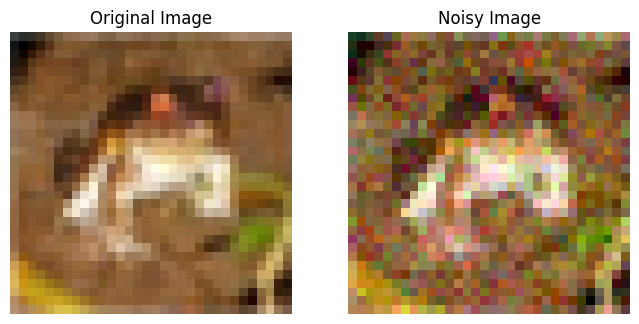

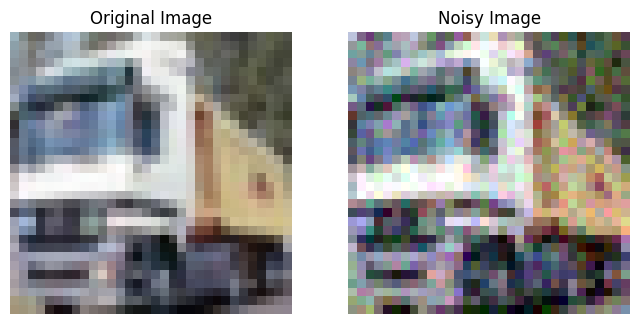

In [ ]:
def add_noise(x_train, noise_factor=0.07):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    noisy_images = x_train + noise
    noisy_images = np.clip(noisy_images, 0., 1.) # the values must be clipped to be between 0 and 1
    return noisy_images

def plot_image(x_train, y_train, index):
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(x_train[index].reshape(32, 32, 3))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(y_train[index].reshape(32, 32, 3))
    plt.title('Noisy Image')
    plt.axis('off')
    
    plt.show()
    
y_train = add_noise(x_train)
plot_image(x_train, y_train, 0)
plot_image(x_train, y_train, 1)

Note that noise values are chosen to be small (0.07) to avoid excessive information loss. The noise model implemented is a simple additive Gaussian noise, where Xnoisy = X + N(0, σ²), with σ = 0.07.

## Dense Denoising Autoencoder

For the dense denoising autoencoder, each image is first flattened. The model is made up of multiple fully connected layers. The model is trained to reconstruct the original image from a noisy input, using mean squared error as loss function. I performed a parallelized grid search to explore different combinations of hyperparameters. ReLU activations are used for the dense layer outputs. To mitigate overfitting (observed as a significantly lower training error compared to validation error) I included dropout for regularization. Lastly, early stopping is employed to prevent overtraining and reduce hardware usage.

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # (i'm using a macbook)
device

device(type='mps')

Starting parallel grid search with 27 combinations...

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.001, batch_size=32

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.001, batch_size=64

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.001, batch_size=128

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0005, batch_size=32

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0005, batch_size=64

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0005, batch_size=128

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0001, batch_size=32

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0001, batch_size=64

Training model with: hidden_dims=[1024, 512, 256, 128], lr=0.0001, batch_size=128

Training model with: hidden_dims=[512, 256, 128], lr=0.001, batch_size=32
Epoch 1/500, Train Loss: 0.044430, Val Loss: 0.034321
Epoch 1/500, Train Loss: 0.039574, Val Loss: 0.032774
Epoch 1/500, Train Loss: 

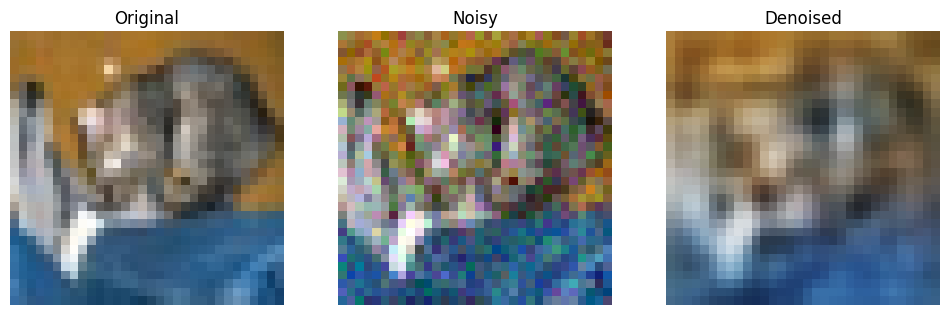

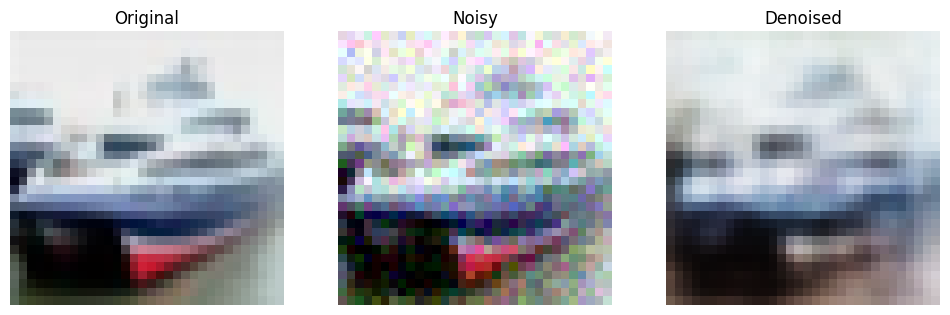

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, hidden_dims=[1024, 512, 256, 128], input_size=3072):  # 32x32x3 = 3072
        super(DenoisingAutoencoder, self).__init__()
        
        # building encoder layers dynamically
        encoder_layers = []
        prev_dim = input_size
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, dim))
            encoder_layers.append(nn.ReLU())
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        # (reverse of encoder)
        decoder_layers = []
        hidden_dims_reversed = hidden_dims[::-1]
        prev_dim = hidden_dims[-1]
        for i, dim in enumerate(hidden_dims_reversed[1:], 0):
            decoder_layers.append(nn.Linear(prev_dim, dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_size))
        decoder_layers.append(nn.Sigmoid()) 
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.bottleneck_size = hidden_dims[-1]
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 32, 32, 3)  # reshape back to image dimensions

x_train_tensor = torch.FloatTensor(x_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
x_test_tensor = torch.FloatTensor(x_test).to(device)

def get_data_loaders(batch_size, val_split=0.2):
    train_dataset = TensorDataset(y_train_tensor, x_train_tensor)  # input is noisy, target is clean
    
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    
    train_subset, val_subset = random_split(
        train_dataset, 
        [train_size, val_size]
    )
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=500, patience=20):
    model.train()
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for noisy_imgs, clean_imgs in train_loader:
            optimizer.zero_grad()
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                outputs = model(noisy_imgs)
                loss = criterion(outputs, clean_imgs)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model_state)
                break
    
    if counter < patience and best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses, best_val_loss

def visualize_results(model, x_test, index=0):
    model.eval()
    with torch.no_grad():
        noisy_test = add_noise(x_test)
        noisy_img = torch.FloatTensor(noisy_test[index:index+1]).to(device)
        
        denoised_img = model(noisy_img).cpu().numpy()[0]
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(x_test[index])
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(noisy_test[index])
        plt.title('Noisy')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(denoised_img)
        plt.title('Denoised')
        plt.axis('off')
        
        plt.show()

def train_model_with_params(params):
    hidden_dims, lr, batch_size = params
    print(f"\nTraining model with: hidden_dims={hidden_dims}, lr={lr}, batch_size={batch_size}")
    model = DenoisingAutoencoder(hidden_dims=hidden_dims).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader, val_loader = get_data_loaders(batch_size)
    _, _, best_val_loss = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=500, patience=20)
    print(f"Completed training with val_loss: {best_val_loss:.6f}")
    
    return {
        'hidden_dims': hidden_dims,
        'learning_rate': lr,
        'batch_size': batch_size,
        'val_loss': best_val_loss,
        'model_state': copy.deepcopy(model.state_dict())
    }

param_grid = {
    'hidden_dims': [
        [1024, 512, 256, 128], # the decoder will use the same #units for each layer, but in reverse order.
        [512, 256, 128],
        [2048, 1024, 512, 256]
    ],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
}

param_combinations = list(itertools.product(
    param_grid['hidden_dims'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
))

print(f"Starting parallel grid search with {len(param_combinations)} combinations...")
results = []

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_to_params = {executor.submit(train_model_with_params, params): params for params in param_combinations}
    
    for future in concurrent.futures.as_completed(future_to_params):
        params = future_to_params[future]
        try:
            result = future.result()
            results.append(result)
            print(f"Completed: hidden_dims={params[0]}, lr={params[1]}, batch_size={params[2]}, val_loss={result['val_loss']:.6f}")
        except Exception as e:
            print(f"Error with parameters {params}: {e}")

best_result = min(results, key=lambda x: x['val_loss'])

print("\nBest parameters:")
print(f"Hidden dimensions: {best_result['hidden_dims']}")
print(f"Learning rate: {best_result['learning_rate']}")
print(f"Batch size: {best_result['batch_size']}")
print(f"Best validation loss: {best_result['val_loss']:.6f}")

best_model = DenoisingAutoencoder(hidden_dims=best_result['hidden_dims']).to(device)
best_model.load_state_dict(best_result['model_state'])

print("\nTraining best model with more epochs...")
best_train_loader, best_val_loader = get_data_loaders(best_result['batch_size'])
criterion = nn.MSELoss()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_result['learning_rate'])
train(best_model, best_train_loader, best_val_loader, criterion, best_optimizer, num_epochs=500, patience=20)

visualize_results(best_model, x_test, index=0)
visualize_results(best_model, x_test, index=1)

Qualitatively, the results from the dense autoencoder are not very impressive. The performance significantly improves when using a convolutional-based autoencoder instead. A detailed quantitative comparison between both approaches is provided at the end of the report.

## Convolutional Denoising Autoencoder

For the convolutional approach, I designed an autoencoder that leverages the spatial structure of images. Unlike the dense model which flattens the images, this model maintains the image dimensions throughout the network. The encoder consists of multiple convolutional layers with ReLU activations and max pooling for downsampling. The decoder uses transposed convolutions (deconvolutions) to upsample the feature maps back to the original image size. 

To find a nice architecture, I performed a similar grid search as the one for the dense model, exploring different filter configurations, learning rates, and batch sizes.

In [6]:
# for convolutional model we need to change format from NHWC to NCHW
x_train_conv = np.transpose(x_train, (0, 3, 1, 2)) 
y_train_conv = np.transpose(y_train, (0, 3, 1, 2))
x_test_conv = np.transpose(x_test, (0, 3, 1, 2))

x_train_tensor_conv = torch.FloatTensor(x_train_conv).to(device)
y_train_tensor_conv = torch.FloatTensor(y_train_conv).to(device)
x_test_tensor_conv = torch.FloatTensor(x_test_conv).to(device)

def get_conv_data_loaders(batch_size, val_split=0.2):
    train_dataset = TensorDataset(y_train_tensor_conv, x_train_tensor_conv)
    
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    
    train_subset, val_subset = random_split(
        train_dataset, [train_size, val_size], 
    )
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

class ConvDenoisingAutoencoder(nn.Module):
    def __init__(self, filters=[32, 64, 128]):
        super(ConvDenoisingAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, filters[0], kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(filters[0], filters[1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(filters[1], filters[2], kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(filters[2], filters[1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(filters[1], filters[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(filters[0], 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def visualize_conv_results(model, x_test_conv, index=0):
    model.eval()
    with torch.no_grad():
        noisy_test = add_noise(np.transpose(x_test_conv, (0, 2, 3, 1))) 
        noisy_test_conv = np.transpose(noisy_test, (0, 3, 1, 2)) 
        noisy_img = torch.FloatTensor(noisy_test_conv[index:index+1]).to(device)
        
        denoised_img = model(noisy_img).cpu().numpy()[0]
        
        denoised_img = np.transpose(denoised_img, (1, 2, 0))
        original_img = np.transpose(x_test_conv[index], (1, 2, 0))
        noisy_img_display = np.transpose(noisy_test_conv[index], (1, 2, 0))
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(noisy_img_display)
        plt.title('Noisy')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(denoised_img)
        plt.title('Denoised')
        plt.axis('off')
        
        plt.show()

def train_conv_model_with_params(params):
    filters, lr, batch_size = params
    
    param_id = f"filters_{'-'.join(map(str, filters))}_lr_{lr}_batch_{batch_size}"
    tmp_file = f"tmp_conv_result_{param_id}.json"
    
    if os.path.exists(tmp_file):
        try:
            with open(tmp_file, 'r') as f:
                saved_result = json.load(f)
            print(f"Loaded existing result for {param_id}")
            
            model = ConvDenoisingAutoencoder(filters=filters).to(device)
            state_dict = {}
            for key, value in saved_result['model_state'].items():
                state_dict[key] = torch.tensor(value)
            
            saved_result['model_state'] = state_dict
            return saved_result
        except Exception as e:
            print(f"Error loading saved result: {e}. Recomputing...")
    
    model = ConvDenoisingAutoencoder(filters=filters).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loader, val_loader = get_conv_data_loaders(batch_size=batch_size)
    
    _, _, val_loss = train(
        model, train_loader, val_loader, criterion, optimizer, 
        num_epochs=500, patience=5
    )
    
    result = {
        'filters': filters,
        'learning_rate': lr,
        'batch_size': batch_size,
        'val_loss': val_loss,
        'model_state': model.state_dict()
    }
    
    serializable_state = {}
    for key, value in result['model_state'].items():
        serializable_state[key] = value.cpu().numpy().tolist()
    
    serializable_result = {
        'filters': result['filters'],
        'learning_rate': result['learning_rate'],
        'batch_size': result['batch_size'],
        'val_loss': result['val_loss'],
        'model_state': serializable_state
    }
    
    with open(tmp_file, 'w') as f: # i've tested different combinations at different times, so i needed to save results in json (the process took hours).
        json.dump(serializable_result, f)
    
    return result

param_grid_conv = {
    'filter_options': [
        [16, 32, 64],
        [32, 64, 128],
        [64, 128, 256]
    ], 
    "learning_rates": [0.0001, 0.001, 0.01],
    "batch_sizes": [32, 64, 128]
}

conv_param_combinations = list(itertools.product(
    param_grid_conv['filter_options'], 
    param_grid_conv['learning_rates'],
    param_grid_conv['batch_sizes']
))

print(f"Starting parallel grid search for convolutional model with {len(conv_param_combinations)} combinations...")
conv_results = []

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_to_params = {executor.submit(train_conv_model_with_params, params): params 
                        for params in conv_param_combinations}
    
    for future in concurrent.futures.as_completed(future_to_params):
        params = future_to_params[future]
        try:
            result = future.result()
            conv_results.append(result)
            print(f"Completed: filters={params[0]}, lr={params[1]}, batch_size={params[2]}, val_loss={result['val_loss']:.6f}")
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
            
best_conv_result = min(conv_results, key=lambda x: x['val_loss'])
    
print("\nBest parameters for convolutional model:")
print(f"Filters: {best_conv_result['filters']}")
print(f"Learning rate: {best_conv_result['learning_rate']}")
print(f"Batch size: {best_conv_result['batch_size']}")
print(f"Best validation loss: {best_conv_result['val_loss']:.6f}")
    
conv_model = ConvDenoisingAutoencoder(filters=best_conv_result['filters']).to(device)
conv_model.load_state_dict(best_conv_result['model_state'])
    
print("\nTraining best convolutional model with more epochs...")
best_train_loader, best_val_loader = get_conv_data_loaders(batch_size=best_conv_result['batch_size'])
criterion = nn.MSELoss()
best_optimizer = optim.Adam(conv_model.parameters(), lr=best_conv_result['learning_rate'])
train_losses, val_losses, _ = train(
    conv_model, best_train_loader, best_val_loader, criterion, best_optimizer, 
    num_epochs=500, patience=10
)

Starting parallel grid search for convolutional model with 27 combinations...
Loaded existing result for filters_16-32-64_lr_0.001_batch_32
Loaded existing result for filters_16-32-64_lr_0.01_batch_64
Loaded existing result for filters_16-32-64_lr_0.0001_batch_128
Loaded existing result for filters_16-32-64_lr_0.0001_batch_64
Loaded existing result for filters_16-32-64_lr_0.001_batch_128
Loaded existing result for filters_16-32-64_lr_0.001_batch_64
Loaded existing result for filters_32-64-128_lr_0.0001_batch_32
Loaded existing result for filters_16-32-64_lr_0.0001_batch_32
Loaded existing result for filters_16-32-64_lr_0.01_batch_32
Loaded existing result for filters_16-32-64_lr_0.01_batch_128
Completed: filters=[16, 32, 64], lr=0.001, batch_size=64, val_loss=0.005052
Completed: filters=[16, 32, 64], lr=0.0001, batch_size=128, val_loss=0.005581
Completed: filters=[16, 32, 64], lr=0.0001, batch_size=32, val_loss=0.005371
Completed: filters=[32, 64, 128], lr=0.0001, batch_size=32, val_lo

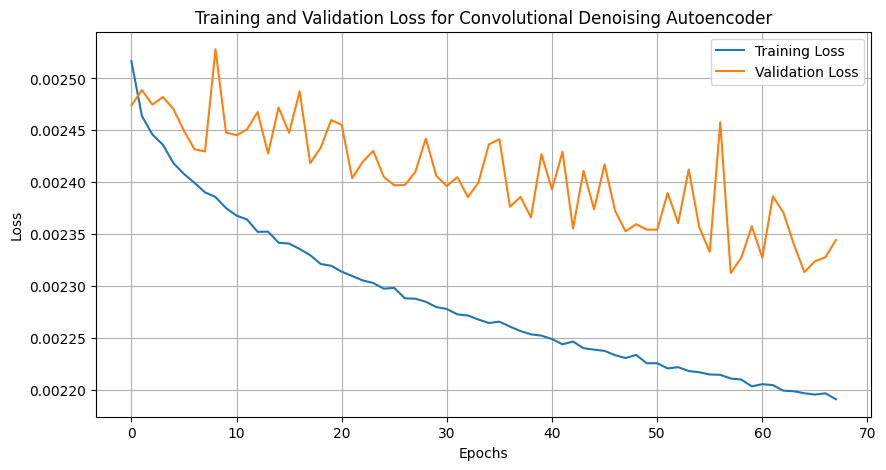

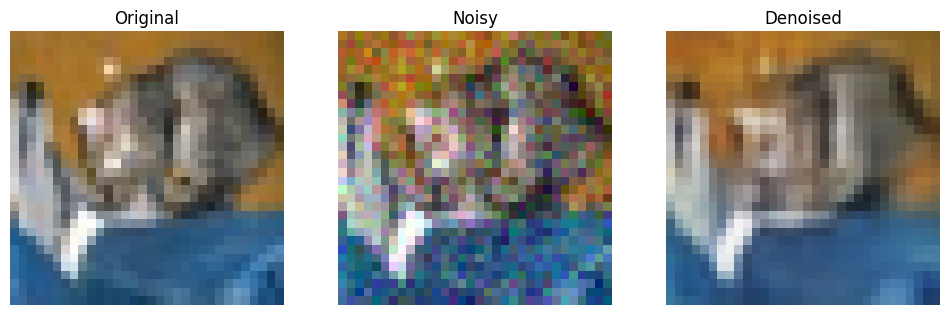

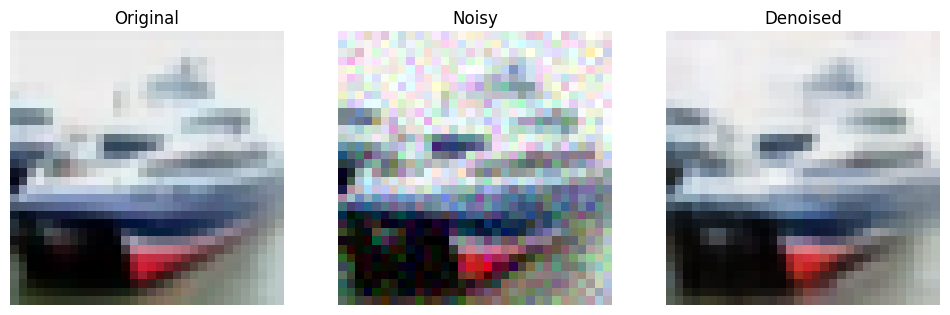

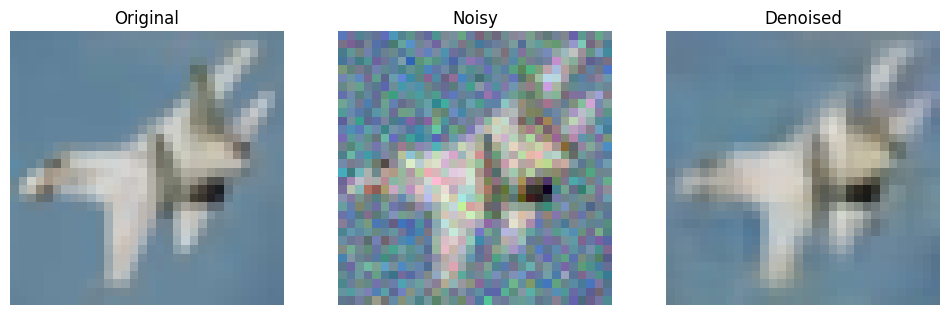

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Convolutional Denoising Autoencoder')
plt.legend()
plt.grid(True)
plt.show()

visualize_conv_results(conv_model, x_test_conv, index=0)
visualize_conv_results(conv_model, x_test_conv, index=1)
visualize_conv_results(conv_model, x_test_conv, index=10)


In [26]:
abs(val_losses[-1] - train_losses[-1]) / train_losses[-1]

0.07007522627016458

We can observe two things:
1. The results are qualitatively better compared to the dense autoencoder. The model reconstructs the original image with much less noise.
2.  While some overfitting is still present (the validation loss is higher than the training loss), the plot exaggerates the difference due to its scale. In reality, the relative difference between training and validation loss at the end of training is approximately 7%: a small generalization gap.

## Quantitative comparison

For the quantitative comparison, I used the following metrics:

- _Mean Squared Error_: measures the average squared difference between the original and reconstructed pixel values. Lower values indicate better reconstruction quality, with 0 representing perfect reconstruction. MSE is sensitive to pixel-wise errors but doesn't necessarily reflect perceptual quality. The convolutional model achieved a **54.71% reduction** in MSE compared to the dense model, demonstrating significantly more accurate pixel value reconstruction.

- _Peak Signal-to-Noise Ratio_: quantifies the ratio between the maximum possible power of the signal and the power of corrupting noise, expressed in decibels (dB). Higher values indicate better quality, with increases of even 1-2 dB considered significant improvements. The convolutional model's **26.74 dB** represents good image quality, with a **14.41% improvement** over the dense model, indicating much cleaner signal reproduction.

- _Structural Similarity Index_: evaluates the perceived quality of images by assessing structural information, contrast, and luminance. Unlike MSE and PSNR, SSIM better aligns with human visual perception, with values ranging from 0 to 1 (higher is better). The convolutional model achieved **0.8822**, representing excellent structural preservation and a **12.53% improvement** over the dense model, indicating superior preservation of features that matter to human observers.

In [21]:
def calculate_metrics(model, images, is_conv=False):
    model.eval()
    with torch.no_grad():
        if is_conv:
            images_nhwc = np.transpose(images, (0, 2, 3, 1)) 
            noisy_images = add_noise(images_nhwc)
            noisy_images_nchw = np.transpose(noisy_images, (0, 3, 1, 2))
            noisy_tensor = torch.FloatTensor(noisy_images_nchw).to(device)
            
            denoised_images = model(noisy_tensor)
            original_tensor = torch.FloatTensor(images).to(device)
            mse = nn.MSELoss()(denoised_images, original_tensor).item()
            
            denoised_images_np = denoised_images.cpu().numpy()
            denoised_images_nhwc = np.transpose(denoised_images_np, (0, 2, 3, 1))
            original_images_nhwc = np.transpose(images, (0, 2, 3, 1))
        else:
            original_images_nhwc = np.transpose(images, (0, 2, 3, 1))
            noisy_images = add_noise(original_images_nhwc)
            noisy_tensor = torch.FloatTensor(noisy_images).to(device)
            
            denoised_images = model(noisy_tensor)
            original_tensor = torch.FloatTensor(original_images_nhwc).to(device)
            mse = nn.MSELoss()(denoised_images, original_tensor).item()
            
            denoised_images_nhwc = denoised_images.cpu().numpy()
        
        psnr_values = []
        ssim_values = []
        data_range = 1.0
        
        for i in range(len(original_images_nhwc)):
            psnr_val = psnr(original_images_nhwc[i], denoised_images_nhwc[i], data_range=data_range)
            ssim_val = ssim(original_images_nhwc[i], denoised_images_nhwc[i], 
                           data_range=data_range, 
                           channel_axis=2)
            
            psnr_values.append(psnr_val)
            ssim_values.append(ssim_val)
        
        return mse, np.mean(psnr_values), np.mean(ssim_values)

fc_mse, fc_psnr, fc_ssim = calculate_metrics(best_model, x_test_conv, is_conv=False)
conv_mse, conv_psnr, conv_ssim = calculate_metrics(conv_model, x_test_conv, is_conv=True)

print(f"Fully Connected Autoencoder:")
print(f"  MSE: {fc_mse:.6f}")
print(f"  PSNR: {fc_psnr:.2f} dB")
print(f"  SSIM: {fc_ssim:.4f}")
print("\nConvolutional Autoencoder:")
print(f"  MSE: {conv_mse:.6f}")
print(f"  PSNR: {conv_psnr:.2f} dB")
print(f"  SSIM: {conv_ssim:.4f}")

mse_improvement = ((fc_mse - conv_mse) / fc_mse) * 100
psnr_improvement = ((conv_psnr - fc_psnr) / fc_psnr) * 100
ssim_improvement = ((conv_ssim - fc_ssim) / fc_ssim) * 100

print("\nImprovement with Convolutional Autoencoder:")
print(f"  MSE: {mse_improvement:.2f}% reduction")
print(f"  PSNR: {psnr_improvement:.2f}% increase")
print(f"  SSIM: {ssim_improvement:.2f}% increase")


Fully Connected Autoencoder:
  MSE: 0.005181
  PSNR: 23.37 dB
  SSIM: 0.7839

Convolutional Autoencoder:
  MSE: 0.002346
  PSNR: 26.74 dB
  SSIM: 0.8821

Improvement with Convolutional Autoencoder:
  MSE: 54.71% reduction
  PSNR: 14.41% increase
  SSIM: 12.53% increase


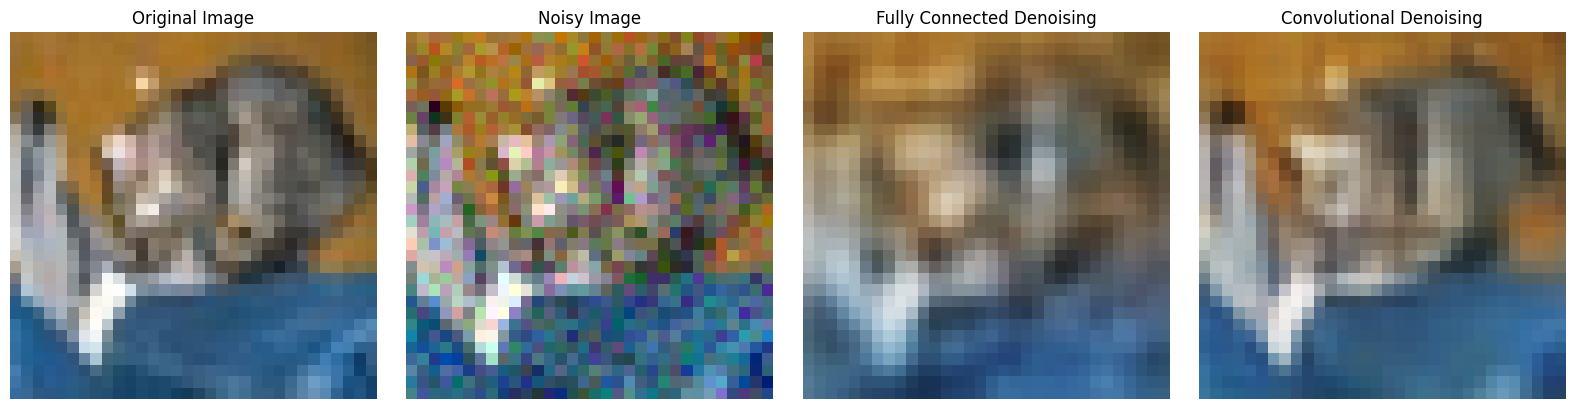

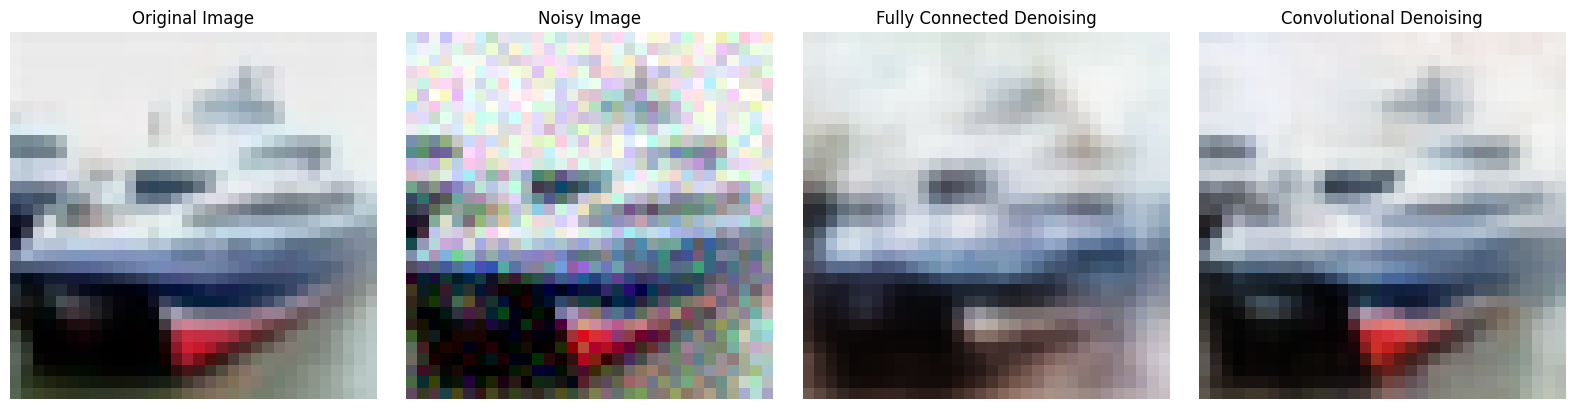

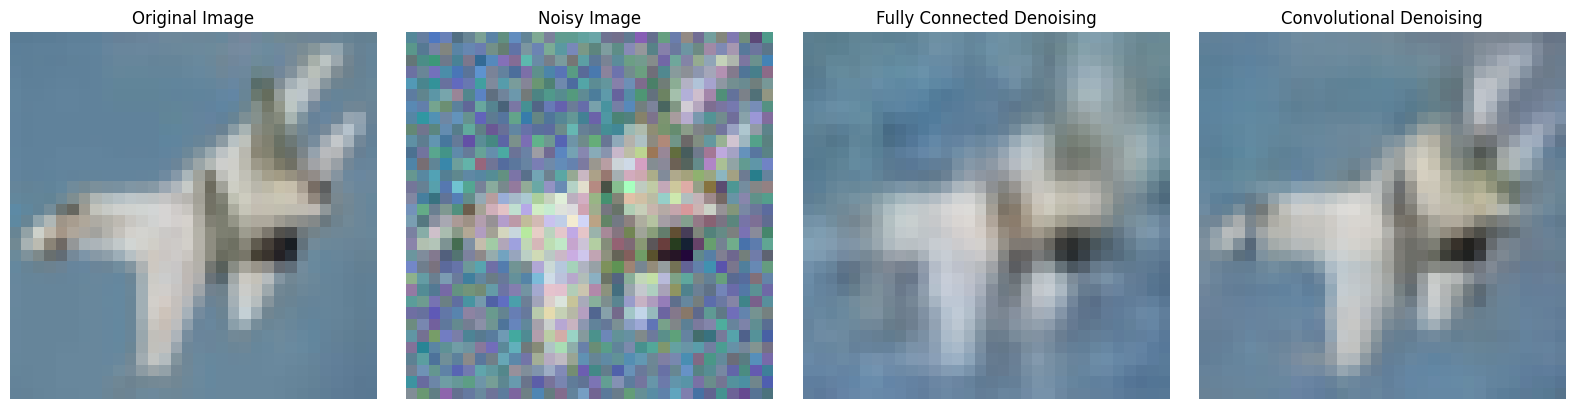

In [24]:
def plot_comparison(
    test_idx,
    x_test,
    best_model,
    conv_model
):
    plt.figure(figsize=(16, 4))
    original_img = np.transpose(x_test[test_idx], (1, 2, 0))
    plt.subplot(1, 4, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    noisy_test = add_noise(np.transpose(x_test, (0, 2, 3, 1)))
    noisy_img = noisy_test[test_idx]
    plt.subplot(1, 4, 2)
    plt.imshow(noisy_img)
    plt.title('Noisy Image')
    plt.axis('off')

    with torch.no_grad():
        noisy_tensor = torch.FloatTensor(noisy_img[np.newaxis, ...]).to(device)
        fc_denoised = best_model(noisy_tensor).cpu().numpy()[0]
        
    plt.subplot(1, 4, 3)
    plt.imshow(fc_denoised)
    plt.title('Fully Connected Denoising')
    plt.axis('off')

    with torch.no_grad():
        noisy_test_conv = np.transpose(noisy_test, (0, 3, 1, 2))
        noisy_tensor = torch.FloatTensor(noisy_test_conv[test_idx:test_idx+1]).to(device)
        conv_denoised = conv_model(noisy_tensor).cpu().numpy()[0]
        conv_denoised = np.transpose(conv_denoised, (1, 2, 0))
        
    plt.subplot(1, 4, 4)
    plt.imshow(conv_denoised)
    plt.title('Convolutional Denoising')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
plot_comparison(0, x_test_conv, best_model, conv_model)
plot_comparison(1, x_test_conv, best_model, conv_model)
plot_comparison(10, x_test_conv, best_model, conv_model)  


## Conclusions
    
The experiments conducted in this notebook clearly demonstrate the significant advantage of convolutional architectures over fully-connected networks for image denoising tasks. Quantitative metrics strongly support this finding, with the convolutional model showing substantial improvements across all evaluation criteria. This performance gap stems from the fundamental architectural differences between the two approaches.
  
Despite these improvements, some fine details in the images are still lost during reconstruction. While deeper architectures should be explored, the current configurations already require several hours to train (especially with grid search). Additionally, the noise level was fixed; performance would likely vary with different noise intensities.
  
Several potential improvements could be implemented, including: deeper networks, different noise types and intensities, batch normalization layers, perceptual loss functions, and testing on diverse datasets to evaluate how well the models generalize.
  
It was fascinating to observe how the convolutional model preserved structural elements even when individual pixel values weren't perfectly reconstructed. This observation aligns with the higher SSIM scores and supports the idea that convolutional networks are inherently better suited for capturing the hierarchical nature of visual information.
  
I hope you enjoyed this notebook! 😊

### References:

- Youtube video (regarding the order of the ARMA model) - channel of Thibaut Modrzyk, PhD student in deep learning at the Claude Bernard Lyon 1 University: [https://www.youtube.com/watch?v=0V96wE7lY4w](https://www.youtube.com/watch?v=0V96wE7lY4w)

- Wikipedia page of the Autoencoder: [https://en.wikipedia.org/wiki/Autoencoder](https://en.wikipedia.org/wiki/Autoencoder)

- Our lectures :)

### Links:

- Link to open the github repo: [https://github.com/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/denoising-autoencoder.ipynb](https://github.com/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/denoising-autoencoder.ipynb)

- Link to open it in colab: [https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/denoising-autoencoder.ipynb](https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/denoising-autoencoder.ipynb)